In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re
import requests

import twitter_credentials


In [4]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
if response.status_code == 200:
    print('Success!')
elif response.status_code == 404:
    print('Not Found.')

Success!


In [5]:
images = pd.read_csv('image_predictions.tsv', sep = '\t', encoding = 'utf-8')

In [6]:
images.duplicated().any()

False

In [7]:
df_1 = pd.read_csv('twitter_archive_enhanced.csv')

In [8]:
df_1['cute_name'] = df_1['doggo'].str.cat(df_1['pupper']
                                         .replace('None','')).str.cat(df_1['floofer']
                                                                      .replace('None','')).str.cat(df_1['pupper']
                                                                                                   .replace('None','')).str.cat(df_1['puppo']
                                                                                                                                .replace('None',''))

In [9]:
df_1['cute_name'] = df_1.cute_name.replace('Nonefloofer','floofer')
df_1['cute_name'] = df_1.cute_name.replace('Nonepupper','pupper')
df_1['cute_name'] = df_1.cute_name.replace('Nonepuppo','puppo')
df_1['cute_name'] = df_1.cute_name.replace('None','Other')

In [10]:
df_1.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,cute_name
0,8.924210e+17,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,Other


In [11]:
df_1.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                   'retweeted_status_user_id','retweeted_status_timestamp',
                   'doggo', 'floofer','pupper', 'puppo'], inplace=True)

In [12]:
df_1.tweet_id.head()

0    8.924210e+17
1    8.921770e+17
2    8.918150e+17
3    8.916900e+17
4    8.913280e+17
Name: tweet_id, dtype: float64

In [13]:
with pd.option_context('float_format', '{:.0f}'.format):  
    print(df_1.tweet_id.head())

0   892421000000000000
1   892177000000000000
2   891815000000000000
3   891690000000000000
4   891328000000000000
Name: tweet_id, dtype: float64


In [14]:
#Pull status number from a different source

In [15]:
df_1.expanded_urls.isnull().any()

True

In [16]:
#Bypass loop errors during extraction

In [17]:
df_1['expanded_urls'] = df_1.expanded_urls.fillna(value='https://www.twitter.com')

In [18]:
urls = df_1.expanded_urls

In [19]:
urls = list(urls)

In [20]:
status= []
for i in range(len(urls)): 
    t= urls[i]
    if bool(re.search(r'\d', t)) == True:
        twt = re.findall(r'\d+', t)[0]
        status.append(twt)
    else:
        status.append('NaN')

In [21]:
status[:5]

['892420643555336193',
 '892177421306343426',
 '891815181378084864',
 '891689557279858688',
 '891327558926688256']

In [22]:
len(df_1.expanded_urls) == len(status)

True

In [23]:
df_1['tweet_status'] = status

In [24]:
df_1.tweet_id[0] == df_1.tweet_status[0]

False

In [25]:
df_1['tweet_id'] = status

In [26]:
df_1.tweet_id.isnull().any()

False

In [27]:
tweet_ids = status
len(tweet_ids)

2356

In [28]:
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, outfile)
#            outfile.write('\n')
#        except tweepy.TweepError as e:
#            print("Fail")
#            fails_dict[tweet_id] = e
            
#            pass
#end = timer()
#print(end - start)
#print(fails_dict)


In [29]:
#df_2 = pd.DataFrame(columns=['tweet_id','retweet count','favorite_count'])

#with open('tweet_json.txt') as i:
#    for line in i:
#        stat = json.loads(line)
#        tweet_id = stat['id_str']
#        retweet_count = stat['retweet_count']
#        favorite_count = stat['favorite_count']
#        df_2 = df_2.append(pd.DataFrame([[tweet_id,retweet_count,
#                                         favorite_count]], 
#                                       columns=['tweet_id',
#                                        'retweet_count', 'favorite_count']))
#df_2 = df_2.reset_index(drop=True)
#df_2.head()
        

In [30]:
#df_2.to_csv (r'C:\Users\tssan\Desktop\Udacity Projects\4wrangle\WeRateDogs.csv',
#                          index = None, header=True, sep='\t', encoding='utf-8')

In [31]:
df_2 = pd.read_csv('WeRateDogs.csv', sep='\t',encoding='utf-8')

In [32]:
df_1.query('tweet_id == "NaN"').count()

tweet_id              78
timestamp             78
source                78
text                  78
expanded_urls         78
rating_numerator      78
rating_denominator    78
name                  78
cute_name             78
tweet_status          78
dtype: int64

In [33]:
df_1['tweet_id'] = df_1.tweet_id.replace('NaN', 0)

In [34]:
df_1 = df_1.astype({'tweet_id':'int64'})

In [35]:
df_2.drop(columns='retweet count', inplace= True)

In [36]:
df_2.duplicated().any()

True

In [37]:
df_1.tweet_id.duplicated().any()

True

In [38]:
df_1[df_1.tweet_id.duplicated()].count()

tweet_id              302
timestamp             302
source                302
text                  302
expanded_urls         302
rating_numerator      302
rating_denominator    302
name                  302
cute_name             302
tweet_status          302
dtype: int64

In [39]:
df_1 = df_1.drop_duplicates(keep='first')

In [40]:
df_2 = df_2.drop_duplicates(keep='first')

In [41]:
len(df_1), len(df_2)

(2356, 2032)

In [42]:
df_1.query('tweet_id == 0').count()

tweet_id              86
timestamp             86
source                86
text                  86
expanded_urls         86
rating_numerator      86
rating_denominator    86
name                  86
cute_name             86
tweet_status          86
dtype: int64

In [43]:
df = df_1.merge(df_2, on='tweet_id', how='inner')

In [44]:
len(df)

2179

In [45]:
df.query('tweet_id == 0').count()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating_numerator      0
rating_denominator    0
name                  0
cute_name             0
tweet_status          0
favorite_count        0
retweet_count         0
dtype: int64

In [46]:
df.tweet_id.duplicated().any()

True

In [47]:
df = df.drop_duplicates(subset=['tweet_id'],keep='first')

In [48]:
len(df)

2026

In [49]:
df = df.merge(images, on='tweet_id', how='inner')

In [50]:
df = df.reset_index(drop=True)
# Get rid of <source, rating_denominator, tweet_status,jpg_url, img_num>
df.drop(columns=['source','tweet_status','img_num'],inplace=True)

# Spotting Errors in Numerators & Denominators

In [51]:
#Searching for errors in data collection where the denominator is less than 10
df.query('rating_denominator < 10')

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
401,810984652412424192,2016-12-19 23:06:23 +0000,Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,Other,5578,1518.0,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True
1959,666287406224695296,2015-11-16 16:11:11 +0000,This is an Albanian 3 1/2 legged Episcopalian...,https://twitter.com/dog_rates/status/666287406...,1,2,an,Other,141,63.0,https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg,Maltese_dog,0.857531,True,toy_poodle,0.063064,True,miniature_poodle,0.025581,True


In [52]:
df.text[401],df.text[1959]

('Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx',
 'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv')

In [53]:
df.loc[401, 'rating_numerator']= np.median(df.rating_numerator)
df.loc[401, 'rating_denominator']= np.median(df.rating_denominator)

df.loc[1959, 'rating_denominator']= 10
df.loc[1959, 'rating_numerator']= 9

In [54]:
df.query('rating_denominator > 10')['rating_denominator']

336      70.0
602      11.0
694     150.0
873     170.0
915      20.0
948      50.0
969      90.0
991      80.0
1009     50.0
1073     50.0
1144     40.0
1311    130.0
1312    110.0
1336     11.0
1436    120.0
1494     80.0
Name: rating_denominator, dtype: float64

#### Normalizing Denominators to a Standard of 10  

In [55]:
norm_numerator= []
norm_denominator= []
for i, row in df.iterrows():
    norm = 10 / row['rating_denominator']
    num = row['rating_numerator'] = row['rating_numerator']* norm
    norm_numerator.append(num)
    den = row['rating_denominator'] = row['rating_denominator']* norm
    norm_denominator.append(den)
    

In [56]:
df['rating_numerator'] = norm_numerator
df['rating_denominator'] = norm_denominator

In [57]:
df.query('rating_denominator !=10')['rating_denominator'].any()

False

# Correcting Ratings Containing Decimal Places

In [58]:
df.groupby(['rating_numerator']).count()

,tweet_id,timestamp,text,expanded_urls,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
rating_numerator,,,,,,,,,,,,,,,,,,,
0.000000,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1.000000,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2.000000,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
3.000000,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
4.000000,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
5.000000,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
6.000000,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
6.363636,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7.000000,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51


In [59]:
df[df['rating_numerator'] == 75]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
262,786709082849828864,2017-02-16 13:11:49 +0000,"RT @dog_rates: This is Logan, the Chow who liv...",https://twitter.com/dog_rates/status/786709082...,75.0,10.0,Logan,Other,19055,6425.0,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,Pomeranian,0.467321,True,Persian_cat,0.122978,False,chow,0.102654,True


In [60]:
df.text[262]

"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…"

#### Using Regular Expression to loop through each text and pull out any digits with decimal places  

In [61]:
for i, row in df.iterrows():
    in_str= row['text']
    split = re.split(r'/' , in_str)[0]
    if bool(re.search(r'\d+\.\d+$', split)) == True:
        after = re.findall(r'\d+\.\d+', split)[0]
        before = df.loc[i, 'rating_numerator']
        df.loc[i, 'rating_numerator'] = after
        print(f"The numerator in row {i} used to be {before} and now is {after}.")
    else:
        pass

The numerator in row 40 used to be 5.0 and now is 13.5.
The numerator in row 262 used to be 75.0 and now is 9.75.
The numerator in row 585 used to be 27.0 and now is 11.27.
The numerator in row 1380 used to be 26.0 and now is 11.26.


In [62]:
df['rating_numerator'] = df['rating_numerator'].astype('float64')
df['rating_denominator'] = df['rating_denominator'].astype('float64')

In [63]:
#No longer need the denominator columns, and the rating_numerator column
#can just become rating (on a standardized scale of 10)
df.drop(columns=['rating_denominator'])
df.rename(columns={"rating_numerator": "rating"},inplace=True)

In [64]:
df.groupby(['rating']).count()

,tweet_id,timestamp,text,expanded_urls,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
rating,,,,,,,,,,,,,,,,,,,
0.000000,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1.000000,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2.000000,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
3.000000,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
4.000000,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
5.000000,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
6.000000,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
6.363636,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7.000000,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51


In [65]:
df[df['rating'] == 420]

,tweet_id,timestamp,text,expanded_urls,rating,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1712,670842764863651840,2015-11-29 05:52:33 +0000,After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420.0,10.0,None,Other,24351,8574.0,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False


In [66]:
df.text[1712]

'After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY'

In [67]:
print(df.jpg_url[1712])

https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg


## At second place Snoop Dogg comes in at very impressive 420 out of 10
<img src="second.jpg"/>

In [68]:
df[df['rating'] == 1776]

,tweet_id,timestamp,text,expanded_urls,rating,rating_denominator,name,cute_name,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
757,749981277374128128,2016-07-04 15:00:45 +0000,This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,Atticus,Other,5253,2528.0,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False


In [69]:
df.text[757]

"This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh"

In [70]:
print(df.jpg_url[757])

https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg


## Congratulation to the winner coming in at 1776 out of 10, no easy feat!
<img src="winner.jpg"/>

These data points were accurately gathered, but are global outliers that greatly increase standard deviation.  
Because of this, I decided to remove the two remaining outliers, and only evaluated the observations of 14 or less.

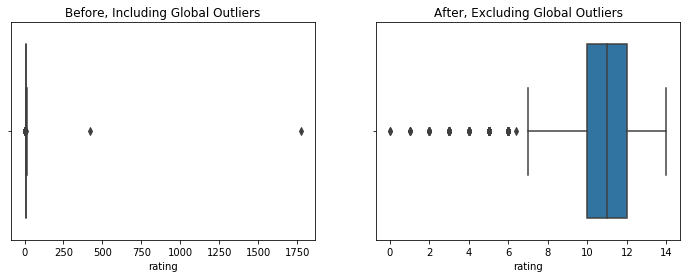

In [71]:
df_before= df.copy()
df = df[df['rating'] < 15]

#df_before= plots of the distribution of the data before and after removing the two outliers
f, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(data=df_before,x= 'rating',orient='w', ax=axes[0])
axes[0].set_title('Before, Including Global Outliers')


sns.boxplot(data=df, x= 'rating',orient='w', ax=axes[1])
axes[1].set_title('After, Excluding Global Outliers');

# Bayesian Analysis of Discrete Ratings

In [72]:
df_rate = df.copy()

In [73]:
# Rounding Ratings to get a discrete scale
for i, row in df_rate.iterrows():
    before = df_rate.loc[i, 'rating']
    after = round(df_rate.rating[i], 0)
    df_rate.loc[i, 'rating'] = after
    if bool(before == after) == False :
        print(f"The rating in row {i} used to be {before} and now is {after}.")
    else:
        pass

The rating in row 40 used to be 13.5 and now is 14.0.
The rating in row 262 used to be 9.75 and now is 10.0.
The rating in row 585 used to be 11.27 and now is 11.0.
The rating in row 602 used to be 8.181818181818182 and now is 8.0.
The rating in row 1336 used to be 6.363636363636363 and now is 6.0.
The rating in row 1380 used to be 11.26 and now is 11.0.


In [126]:
df_rate['p1'].value_counts()

golden_retriever      138
Labrador_retriever     92
Pembroke               88
Chihuahua              79
pug                    54
                     ... 
mortarboard             1
coil                    1
snowmobile              1
leopard                 1
water_bottle            1
Name: p1, Length: 372, dtype: int64

In [128]:
#Golden Retriever
df_gold= (df_rate[df_rate['p1']=='golden_retriever'])
df_gold= df_gold.rating.value_counts().sort_index()
df_gold = df_gold.rename_axis('rating').to_frame('gold_count')
#Labrador Retriever
df_lab= (df_rate[df_rate['p1']=='Labrador_retriever'])
df_lab= df_lab.rating.value_counts().sort_index()
df_lab = df_lab.rename_axis('rating').to_frame('lab_count')
#Pembroke
df_pem= (df_rate[df_rate['p1']=='Pembroke'])
df_pem=df_pem.rating.value_counts().sort_index()
df_pem = df_pem.rename_axis('rating').to_frame('pem_count')
#Chihuahua
df_chih= (df_rate[df_rate['p1']=='Chihuahua'])
df_chih= df_chih.rating.value_counts().sort_index()
df_chih = df_chih.rename_axis('rating').to_frame('chih_count')
#Pug
df_pug= (df_rate[df_rate['p1']=='pug'])
df_pug=df_pug.rating.value_counts().sort_index()
df_pub=df_pug.rename_axis('rating').to_frame('pug_count')

#Combining the top 5 most likley dogs
df_5dogs= pd.concat([df_pem,df_gold, df_lab,df_chih,df_pug],axis=1,sort=True).fillna(0)
df_5dogs= df_5dogs.reset_index().rename(columns={'index' : 'rating','rating' : 'pug_count'})

#Counts of all other dogs and ratings
df_oth = df_rate[(df_rate.p1 != 'golden_retriever') | (df_rate.p1 != 'Labrador_retriever') | (df_rate.p1 !='Chihuahua')| (df_rate.p1 !='Pembroke')| (df_rate.p1 !='pug')]
df_oth = df_oth.rating.value_counts().sort_index()
df_oth = df_oth.rename_axis('rating').to_frame('other_count')

#Combining all top 5 dogs with all others
df_bayes = pd.merge(df_oth, df_5dogs, on='rating',how='left').fillna(0)

#Creating a total column, by first reseting the index and making 'Rating' a string
df_bayes['rating'] = df_bayes['rating'].astype(str)
df_bayes= df_bayes.reset_index(drop=True).set_index('rating')
#Setting a total column
df_bayes.loc[:,'Total'] = df_bayes.sum(axis=1)

In [134]:
#Golden Retriever
df_gold= (df_rate[df_rate['p1']=='golden_retriever'])
df_gold= df_gold.rating.value_counts().sort_index()
df_gold = df_gold.rename_axis('rating').to_frame('gold_count')
#Labrador Retriever
df_lab= (df_rate[df_rate['p1']=='Labrador_retriever'])
df_lab= df_lab.rating.value_counts().sort_index()
df_lab = df_lab.rename_axis('rating').to_frame('lab_count')
#Pembroke
df_pem= (df_rate[df_rate['p1']=='Pembroke'])
df_pem=df_pem.rating.value_counts().sort_index()
df_pem = df_pem.rename_axis('rating').to_frame('pem_count')
#Chihuahua
df_chih= (df_rate[df_rate['p1']=='Chihuahua'])
df_chih= df_chih.rating.value_counts().sort_index()
df_chih = df_chih.rename_axis('rating').to_frame('chih_count')
#Pug
df_pug= (df_rate[df_rate['p1']=='pug'])
df_pug=df_pug.rating.value_counts().sort_index()
df_pub=df_pug.rename_axis('rating').to_frame('pug_count')

#Combining the top 5 most likley dogs
df_5dogs= pd.concat([df_pem,df_gold, df_lab,df_chih,df_pug],axis=1,sort=True).fillna(0)
df_5dogs= df_5dogs.reset_index().rename(columns={'index' : 'rating','rating' : 'pug_count'})


#Creating a total column, by first reseting the index and making 'Rating' a string
df_5dogs['rating'] = df_5dogs['rating'].astype(str)
df_5dogs= df_5dogs.reset_index(drop=True).set_index('rating')
#Setting a total column
df_5dogs.loc[:,'Total'] = df_5dogs.sum(axis=1)

In [135]:
df_bayes

,other_count,pem_count,gold_count,lab_count,chih_count,pug_count,Total
rating,,,,,,,
0.0,2,0.0,0.0,0.0,0.0,0.0,2.0
1.0,4,0.0,0.0,0.0,0.0,0.0,4.0
2.0,10,0.0,0.0,0.0,0.0,0.0,10.0
3.0,19,0.0,0.0,0.0,1.0,1.0,21.0
4.0,15,1.0,0.0,0.0,0.0,0.0,16.0
5.0,32,1.0,0.0,0.0,1.0,0.0,34.0
6.0,33,1.0,0.0,0.0,0.0,1.0,35.0
7.0,51,1.0,0.0,1.0,4.0,2.0,59.0
8.0,96,1.0,3.0,3.0,3.0,2.0,108.0


In [136]:
df_5dogs

,pem_count,gold_count,lab_count,chih_count,pug_count,Total
rating,,,,,,
3.0,0.0,0.0,0.0,1.0,1.0,2.0
4.0,1.0,0.0,0.0,0.0,0.0,1.0
5.0,1.0,0.0,0.0,1.0,0.0,2.0
6.0,1.0,0.0,0.0,0.0,1.0,2.0
7.0,1.0,0.0,1.0,4.0,2.0,8.0
8.0,1.0,3.0,3.0,3.0,2.0,12.0
9.0,0.0,4.0,4.0,7.0,8.0,23.0
10.0,9.0,20.0,22.0,17.0,18.0,86.0
11.0,26.0,27.0,25.0,12.0,10.0,100.0


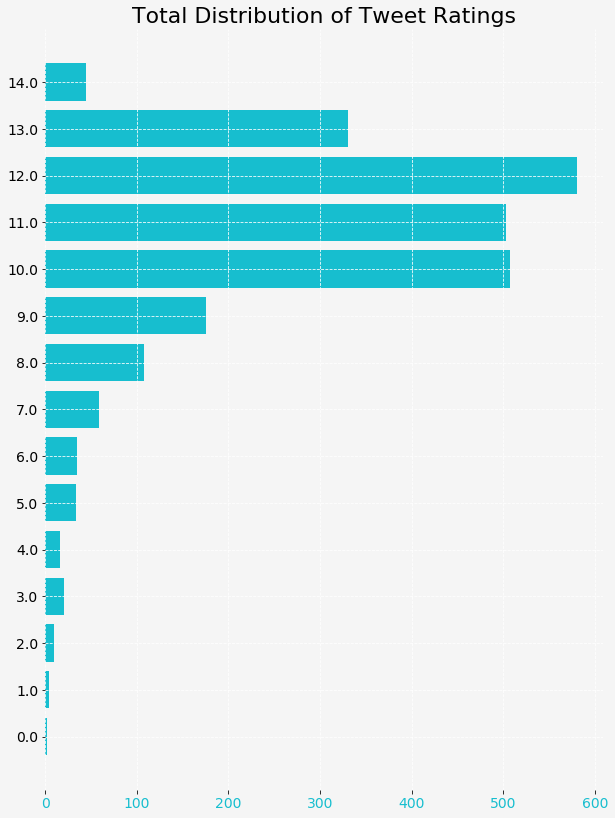

In [237]:
r = df_bayes.index
t = df_bayes.Total
c= sns.color_palette()[9]
f_sz=14

fig = plt.figure(figsize=(10,14), facecolor='whitesmoke')


ax=plt.barh(range(len(r)),t, color=c)
plt.yticks(range(len(r)),r,fontsize=14)
plt.xticks(color=c,fontsize=f_sz)
plt.title('Total Distribution of Tweet Ratings',fontsize=22)
plt.grid(color='white',linestyle='dashed')
plt.box(False)
plt.show()

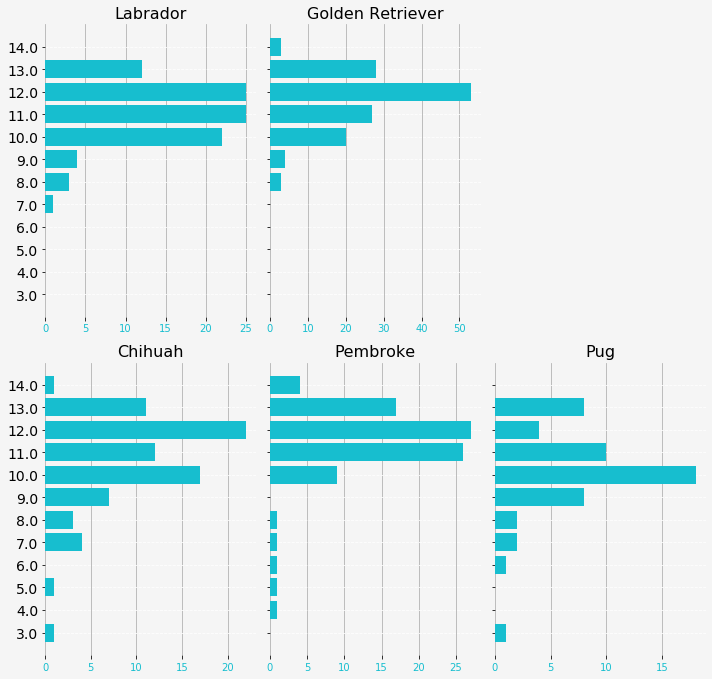

In [208]:
from mpl_toolkits.axes_grid1 import Grid
i = df_bayes.index
t = df_bayes.Total

r = df_5dogs.index
ch = df_5dogs.chih_count
g = df_5dogs.gold_count
l = df_5dogs.lab_count
p = df_5dogs.pem_count
pu = df_5dogs.pug_count
c= sns.color_palette()[9]
f_sz=16

fig = plt.figure(figsize=(10,14), facecolor='whitesmoke')
grid = Grid(fig, rect=111, nrows_ncols=(2,2),
            axes_pad=0.25, label_mode='L')



ax1= plt.subplot(3, 3, 1)
plt.barh(range(len(r)),l, color=c)
plt.yticks(range(len(r)),r,fontsize=14)
plt.xticks(color=c)
plt.box(False)
plt.title('Labrador',fontsize=f_sz)
plt.grid()
ax1.set_axisbelow(True)
ax1.yaxis.grid(color='white', linestyle='dashed')

ax2= plt.subplot(3, 3, 2)
plt.barh(range(len(r)),g, color=c)
plt.yticks(range(len(r)),r)
plt.xticks(color=c)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Golden Retriever',fontsize=f_sz)
plt.grid()
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='white', linestyle='dashed')

ax3 = plt.subplot(3, 3, 4)
plt.barh(range(len(r)),ch, color=c)
plt.yticks(range(len(r)),r,fontsize=14)
plt.xticks(color=c)
plt.box(False)
plt.title('Chihuah',fontsize=f_sz)
plt.grid()
ax3.set_axisbelow(True)
ax3.yaxis.grid(color='white', linestyle='dashed')

ax4 = plt.subplot(3, 3, 5)
plt.barh(range(len(r)),p, color=c)
plt.yticks(range(len(r)),r)
plt.xticks(color=c)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Pembroke',fontsize=f_sz)
plt.grid()
ax4.set_axisbelow(True)
ax4.yaxis.grid(color='white', linestyle='dashed')

ax5 = plt.subplot(3, 3, 6)
plt.barh(range(len(r)),pu, color=c)
plt.yticks(range(len(r)),r)
plt.xticks(color=c)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Pug', fontsize=f_sz)
plt.grid()
ax5.set_axisbelow(True)
ax5.yaxis.grid(color='white', linestyle='dashed')

plt.tight_layout()
plt.show()

# Time Series 

In [ ]:
df_time = df.copy()

In [ ]:
df_time['timestamp'].min(), df_time['timestamp'].max()

In [ ]:
time = df_time['timestamp']

In [ ]:
time = list(time)

In [ ]:
times = []
for i in range(len(time)): 
    t= time[i]
    stamp = t.rpartition(':')[0]
    times.append(stamp)

In [ ]:
times[:5]

In [ ]:
df_time['timestamp'] = times

In [ ]:
df_time['timestamp'] = pd.to_datetime(df_time['timestamp'])

In [ ]:
# TimeSeries of Twitter Activity 

#Favorite and Retweet series
time_faves = pd.Series(data=df_time['favorite_count'].values, index=df_time['timestamp'])
time_retweets = pd.Series(data=df_time['retweet_count'].values, index=df_time['timestamp'])

#Plotting both series to the same axis
size= (12,8)

time_faves.plot(kind='area',figsize=size, label='favorites',
                color='deepskyblue',legend=True)
time_retweets.plot(kind='area',figsize=size, label='retweet',
                   color='crimson',legend=True)

#Labels and preferences for the visualization

plt.title('WeRateDogs Time Series of Favorites and Retweets',fontsize=18)
plt.xlabel('Date',fontsize=18,color='crimson') 
plt.ylabel('Twitter Activity Count',fontsize=18, color='crimson')
plt.xticks(rotation=45)
plt.legend(fontsize=14,frameon=False)

plt.box(False)
plt.show();